In [1]:
import numpy as np
import pandas as pd
import sklearn
import pickle

import matplotlib.pyplot as plt
import cv2

In [58]:
# Load all models
haar = cv2.CascadeClassifier('./model/haarcascade_frontalface_default.xml') # Casscade Classifier
model_svm = pickle.load(open('./model/model_svm.pickle',mode='rb')) # ML model
pca_models = pickle.load(open('./model/pca_dict.pickle',mode='rb')) # pca dictionary


In [59]:
model_pca = pca_models['pca'] # PCA model
mean_face_arr = pca_models['mean_face'] # Mean Face

### Create Pipeline

In [128]:
# step - 01: read image
img = cv2.imread('./data/img_01.jpg')

# step - 02: convert into gray scale
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)

# step - 03: crop the face(using haar cascade classifier)
face_list = haar.detectMultiScale(img_gray,1.5,5)
predictions = []

for x,y,h,w in face_list:
    
    roi = img_gray[y:y+w,x:x+h]
    
    # step - 04: normalizaiton(0 - 1)
    roi = roi/255.0

    # step - 05: resize images (100, 100)
    if roi.shape[1] >100:
        roi_resize = cv2.resize(roi,(100,100),cv2.INTER_AREA)
    else:
        roi_resize = cv2.resize(roi,(100,100),cv2.INTER_CUBIC)
    
    # step - 06: Flattening (1x10000)
    roi_reshape = roi_resize.reshape(1,10000)
    
    # step - 07: subtract with mean
    roi_mean = roi_reshape - mean_face_arr
    
    # step - 08: get eigen image
    eigen_img = model_pca.transform(roi_mean)
    
    # step - 09: Eigen Image for visualization
    eig_img = model_pca.inverse_transform(eigen_img)    
    
    # step - 10: pass to ml model (svm) and get predictions
    results = model_svm.predict(eigen_img)
    prob_score = model_svm.predict_proba(eigen_img)
    prob_score_max = prob_score.max()
    
    # step - 11: generate report
    text = "%s : %d"%(results[0],prob_score_max*100)
    #print(text)
    #defining color based on results
    if results[0] == 'male':
        color = (255,0,255)
    else:
        color = (50,55,255)
    cv2.rectangle(img,(x,y),(x+h,y+w),color,2)
    cv2.rectangle(img,(x,y-30),(x+w,y),color,-1)
    cv2.putText(img,text,(x,y),cv2.FONT_HERSHEY_PLAIN,2,(255,255,255),2)
    output = {
        'roi':roi,
        'eig_img':eig_img,
        'prediction_name':results[0],
        'score':prob_score_max
    }
    
    predictions.append(output)

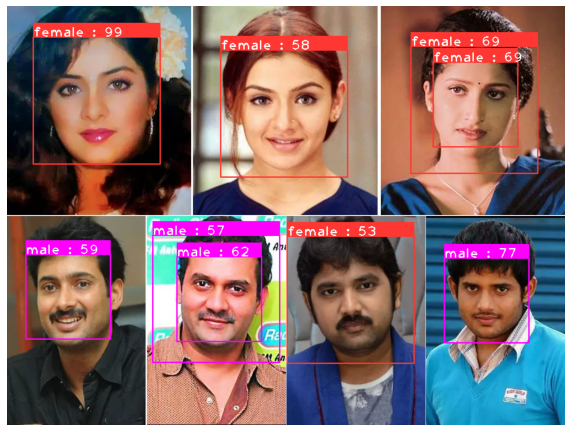

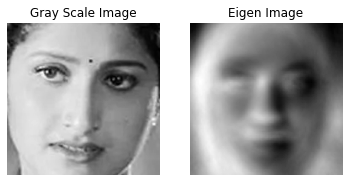

Predicted Gender =  female
Predicted Score = 69.68% 
----------------------------------------------------------------------------------------------------


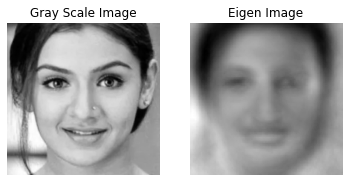

Predicted Gender =  female
Predicted Score = 58.72% 
----------------------------------------------------------------------------------------------------


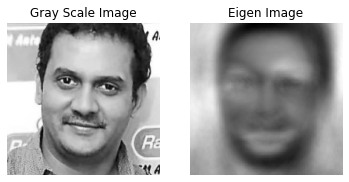

Predicted Gender =  male
Predicted Score = 57.15% 
----------------------------------------------------------------------------------------------------


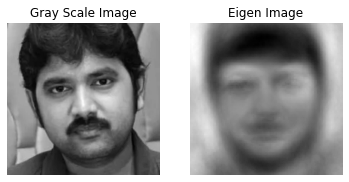

Predicted Gender =  female
Predicted Score = 53.80% 
----------------------------------------------------------------------------------------------------


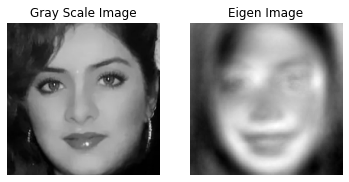

Predicted Gender =  female
Predicted Score = 99.59% 
----------------------------------------------------------------------------------------------------


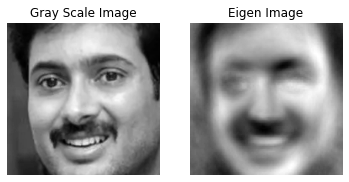

Predicted Gender =  male
Predicted Score = 59.14% 
----------------------------------------------------------------------------------------------------


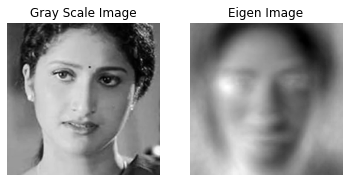

Predicted Gender =  female
Predicted Score = 69.63% 
----------------------------------------------------------------------------------------------------


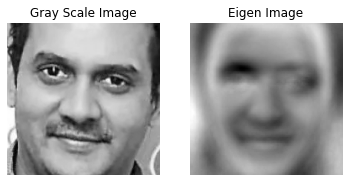

Predicted Gender =  male
Predicted Score = 62.74% 
----------------------------------------------------------------------------------------------------


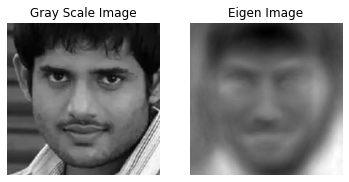

Predicted Gender =  male
Predicted Score = 77.37% 
----------------------------------------------------------------------------------------------------


In [138]:
img_rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,10))
plt.imshow(img_rgb)
plt.axis('off')
plt.show()

## generate report
for i in range(len(predictions)):
    obj_gray = predictions[i]['roi'] #gray_scale
    obj_eig = predictions[i]['eig_img'].reshape(100,100) #eig_img
    plt.subplot(1,2,1)
    plt.imshow(obj_gray,cmap='gray')
    plt.title('Gray Scale Image')
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(obj_eig,cmap='gray')
    plt.title('Eigen Image')
    plt.axis('off')
    
    plt.show()
    print('Predicted Gender = ', predictions[i]['prediction_name'])
    print('Predicted Score = {:,.2f}% '.format(predictions[i]['score']*100))
    
    print('-'*100)